本次对比学习实验以pytorch作为基础框架。

In [7]:
import matplotlib
from d2l import torch as d2l
import torch
from sklearn.manifold import TSNE
import numpy as np
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

该模型是自动编码器，包含一个编码器和一个解码器两部分。
编码器部分由三层卷积层组成，每层后接批标准化和LeakyReLU激活函数，最终通过Flatten层将特征图展平成一维向量，再通过一个全连接层将其映射到128维的潜在空间。解码器部分首先通过一个全连接层将潜在向量重新映射回特征图的形状，然后通过两层转置卷积层，每层后接批标准化和LeakyReLU激活函数，最终输出一层Sigmoid激活函数，生成最终重建的图像。

In [8]:
class AutoEDcoder(nn.Module):
    def __init__(self):
        super(AutoEDcoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(),
            nn.Conv2d(3, 9, 3, 2, 1),
            nn.BatchNorm2d(9),
            nn.LeakyReLU(),
            nn.Conv2d(9, 18, 3, 2, 1),
            nn.BatchNorm2d(18),
            nn.LeakyReLU(),
            nn.Flatten()
        )
        self.fc1 = nn.Linear(18 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 18 * 7 * 7)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(18, 9, 3, 2, 1, output_padding=1),
            nn.BatchNorm2d(9),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(9, 1, 3, 2, 1, output_padding=1),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        code = self.fc1(x)
        # Decoder
        x = self.fc2(code)
        x = x.view(x.size(0), 18, 7, 7)
        out = self.decoder(x)
        return out

定义训练模型函数。
首先，将模型移动到指定的设备（GPU）并设置为训练模式。然后，进入训练循环，对每个训练周期执行以下步骤：
- 1）初始化累计损失为零
- 2）从训练数据加载器中批量获取输入数据和标签，并将它们移动到指定设备上
- 3）将优化器梯度置零
- 4）将输入数据传入模型，获得预测输出
- 5）计算输入数据与预测输出之间的均方误差（MSE）损失
- 6）反向传播损失，更新模型参数
- 7）累计当前批次的损失值。每个周期结束后，打印该周期的总损失，并将其添加到损失列表中以供后续分析。

In [9]:
def train(model, device, train_loader, optimizer, epochs):
    model = model.to(device)
    model.train(True)
    for epoch in range(epochs):
        total_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = nn.MSELoss()(x, y_pred)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'epoch:{epoch}  total_loss:{total_loss}')
        loss_list.append(total_loss)

- eval函数用于评估自动编码器模型的性能。
- 首先，将模型移动到指定设备并设置为评估模式，禁用梯度计算以节省内存和计算资源。然后，在测试数据集上迭代，对每个输入数据进行预测并可视化前16个原始和重构图像。接下来，绘制训练过程中每个epoch的损失变化曲线。之后，通过模型的编码器部分提取特征，并使用t-SNE算法将这些高维特征降维到二维进行可视化，最后绘制散点图，展示不同类别的样本在特征空间中的分布情况。

In [10]:
def eval(model, device, test_loader, epochs):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            y_pred = model(x)
            # 可视化重构结果和原始图像
            fig, axes = plt.subplots(16, 2, figsize=(x[0].size(0) * 2, x[0].size(1) / 1.5))
            axes[0, 0].set_title('Original')
            axes[0, 1].set_title('Reconstructed')
            # 原始图像
            for i in range(16):
                # 原始图像
                axes[i, 0].imshow(x[i].cpu().squeeze(), cmap='gray')
                axes[i, 0].axis('off')

                # 重构图像
                axes[i, 1].imshow(y_pred[i].cpu().squeeze(), cmap='gray')
                axes[i, 1].axis('off')
            plt.tight_layout()
            plt.show()
            break
    x = [i for i in range(epochs)]
    plt.plot(x, loss_list)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    model.eval()
    encoded_features = []  # 用于保存编码后的特征
    original_labels = []  # 用于保存原始标签
    with torch.no_grad():
        for data in test_loader:
            anchor_imgs,labels = data
            anchor_imgs = anchor_imgs.to(device)
            anchor_outputs = model.encoder(anchor_imgs)
            encoded_features.extend(anchor_outputs.cpu().numpy())
            original_labels.extend(labels.cpu().numpy())
            if len(encoded_features) >= 7000:
                break
    encoded_features = np.array(encoded_features)
    tsne = TSNE(n_components=2, random_state=42)
    encoded_features_tsne = tsne.fit_transform(encoded_features)
    plt.rcParams['font.sans-serif'] = ['SimHei'] 
    plt.rcParams['axes.unicode_minus'] = False 
    plt.figure(figsize=(12, 10))  
    plt.scatter(encoded_features_tsne[:, 0], encoded_features_tsne[:, 1], c=original_labels, cmap=plt.cm.tab10,
                marker='o', alpha=0.7)  
    plt.colorbar(ticks=range(10))
    plt.title('自动编码器的 t-SNE 可视化')
    plt.xlabel('特征1')
    plt.ylabel('特征2')
    plt.grid(True)  # 添加网格线
    plt.show()

- 定义批处理大小和损失列表
- 定义数据预处理转换
- 加载Mnist数据集并创建数据加载器
- 设置有关数据集基本参数

In [11]:
batch_size = 128

loss_list = []

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

train_data = datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

size = 1 * 28 * 28
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

- 实例化模型
- 设置训练参数：
- 设置训练的轮数为25。
- 使用Adam优化器，并设置学习率为0.3。
- 训练模型

In [12]:
net = AutoEDcoder()
epochs = 25
train(model=net, device=device, train_loader=train_loader, optimizer=torch.optim.Adam(net.parameters(), lr=0.3),
      epochs=epochs)

C:\Users\23225\anaconda3\envs\dl\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch:0  total_loss:851.4893773794174
epoch:1  total_loss:712.1870564222336
epoch:2  total_loss:585.8765522241592
epoch:3  total_loss:512.8365936279297
epoch:4  total_loss:473.0626201033592
epoch:5  total_loss:450.0967456102371
epoch:6  total_loss:436.0023823976517
epoch:7  total_loss:426.67454493045807
epoch:8  total_loss:420.0627187490463
epoch:9  total_loss:415.34911501407623
epoch:10  total_loss:411.6886512041092
epoch:11  total_loss:408.9857292175293
epoch:12  total_loss:406.87167197465897
epoch:13  total_loss:405.2925777435303
epoch:14  total_loss:404.07702881097794
epoch:15  total_loss:403.1408190727234
epoch:16  total_loss:402.12414836883545
epoch:17  total_loss:401.56671410799026
epoch:18  total_loss:401.0248973965645
epoch:19  total_loss:400.621114552021
epoch:20  total_loss:400.28656965494156
epoch:21  total_loss:400.01247602701187
epoch:22  total_loss:399.6885645389557
epoch:23  total_loss:399.50614798069
epoch:24  total_loss:399.3148586153984


- 模型评估

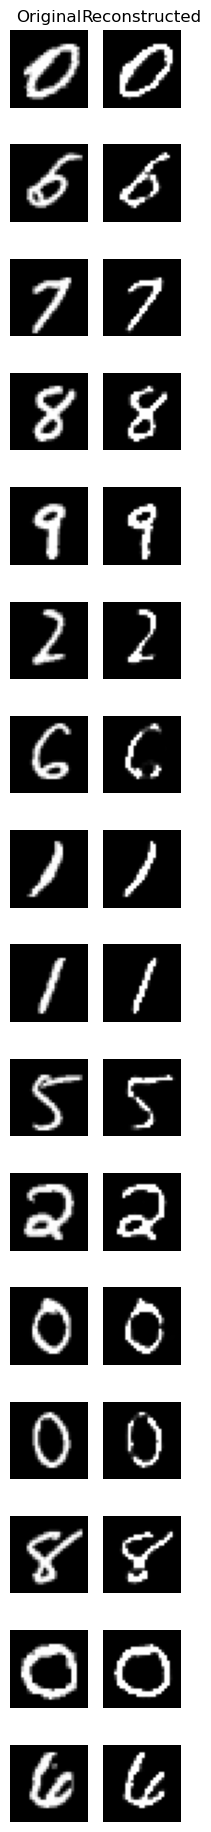

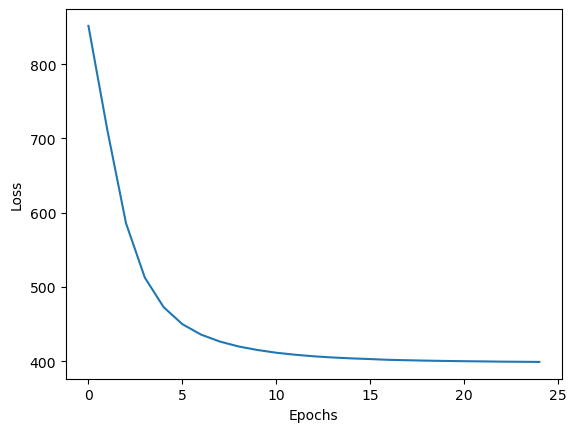

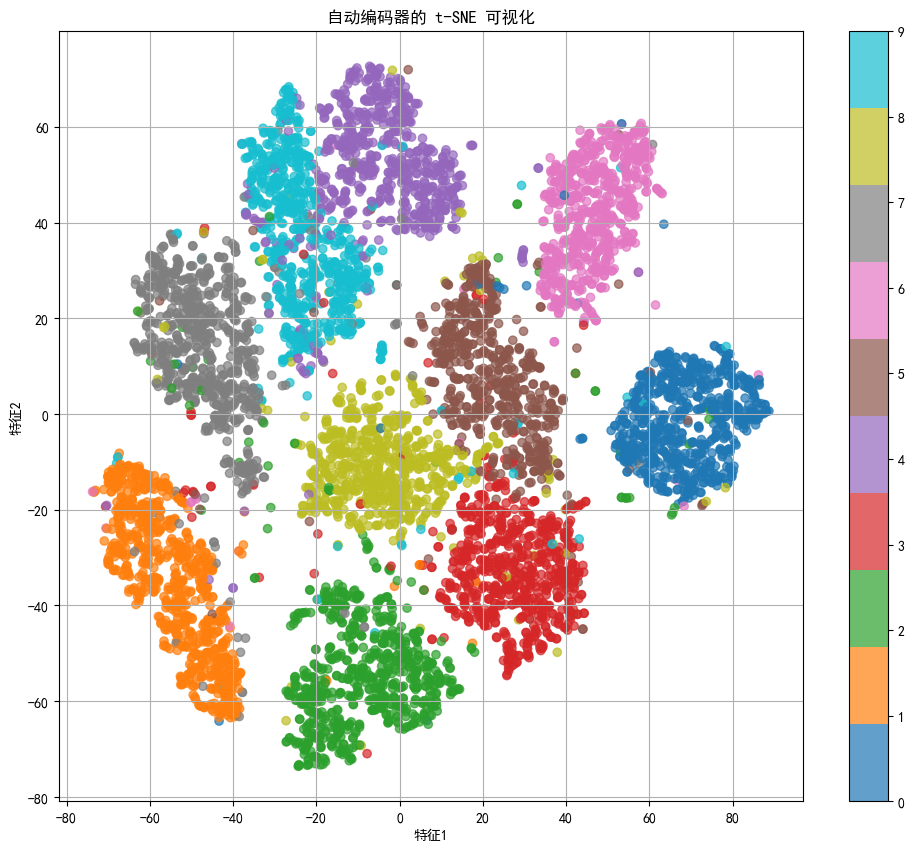

In [13]:
eval(net, device=device, test_loader=test_loader, epochs=epochs)